In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa

In [ ]:
import librosa
from librosa import display
import IPython.display as ipd
import numpy as np
import os
import pandas as pd
import glob 
import matplotlib.pyplot as plt

In [ ]:
path = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/wav_files'
lst = []

for subdir, dirs, files in os.walk(path):
  files.sort()
  i = 0
  for file in files:
    i += 1
    if file[4:5] == '6':
      print(file)
  print(i)

Video class (01 = Educational, 02 = Gaming, 03 = News, 04 = Scenery, 05 = Song, 06 = Sports).

In [ ]:
sample_file = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/wav_files/02_01_01_01.wav'
data, sampling_rate = librosa.load(sample_file)
print(sampling_rate)

22050


In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
ipd.Audio(sample_file)

In [ ]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=sampling_rate, n_mels=25)

In [ ]:
filter_banks

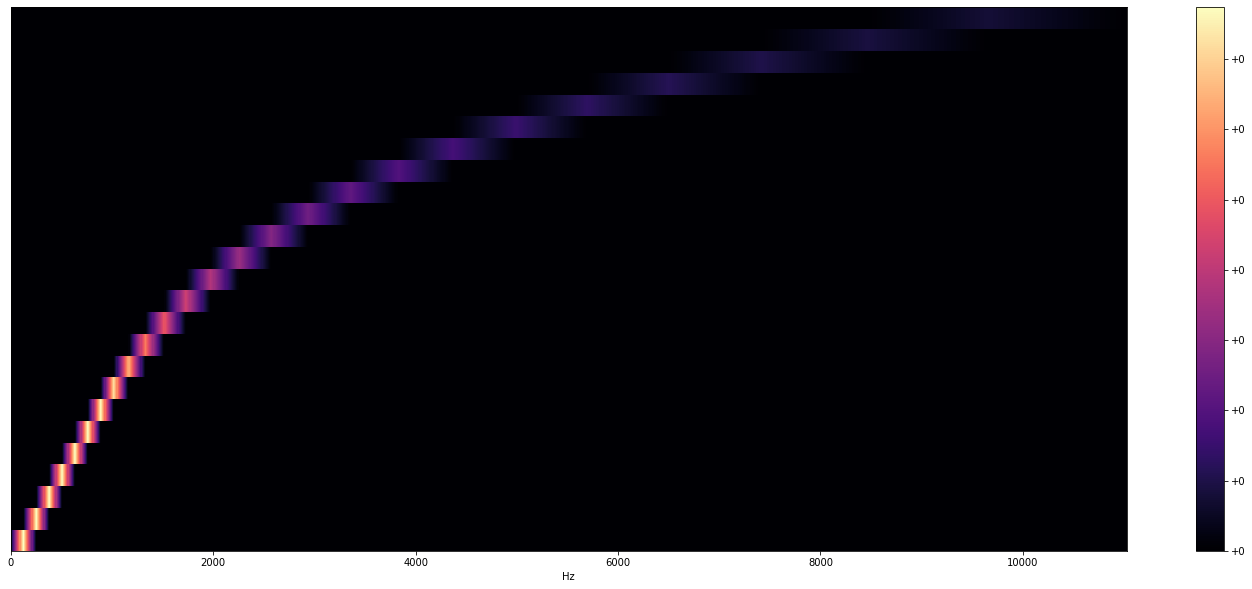

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sampling_rate, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(data, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=25)

In [ ]:
mel_spectrogram

In [ ]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

In [ ]:
log_mel_spectrogram.shape

(25, 217)

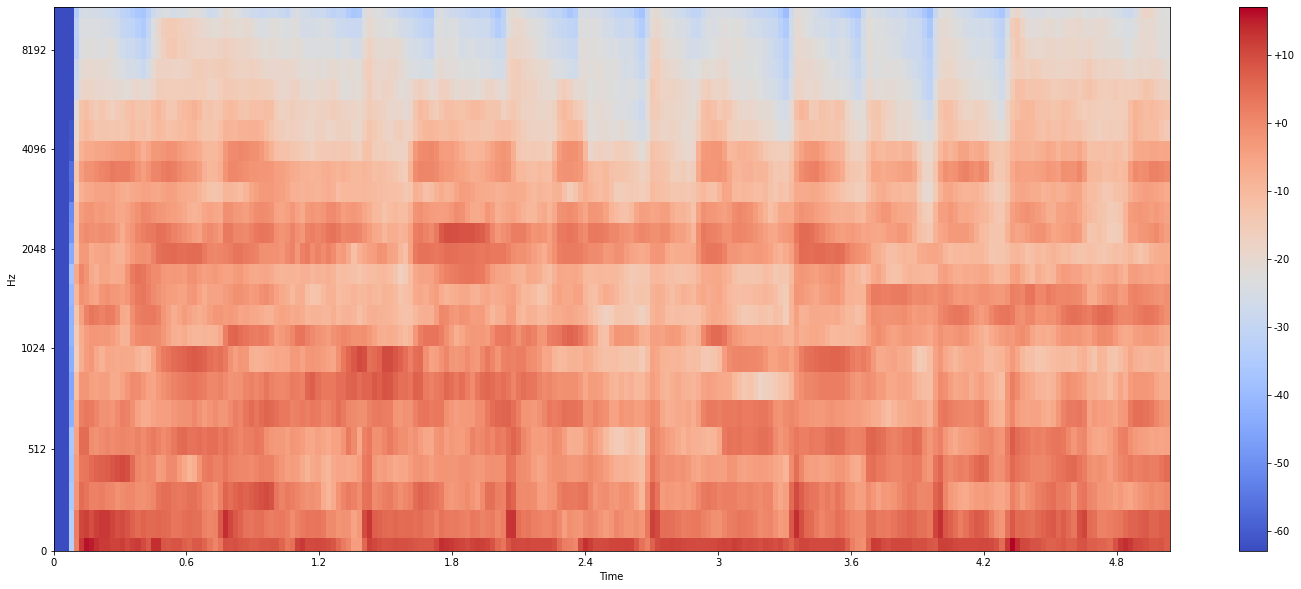

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sampling_rate)
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
import time

lst = []

#Load librosa array, obtain mfcss, store the file and the mcss information in a new array
X, sample_rate = librosa.load(sample_file, res_type='kaiser_fast')
print(X.shape)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
print(mfccs.shape)
# The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
# This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
class_id = int('02_01_01_01.wav'[4:5]) - 1 
arr = mfccs, class_id
lst.append(arr)
print(len(lst[0][0]))

(110592,)
(40,)
40


In [ ]:
import time

path = '/content/drive/MyDrive/Thesis/Media Data Filtering/Dataset/wav_files'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        class_id = int(file[4:5]) - 1 
        arr = mfccs, class_id
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 2060.0782475471497 seconds ---


In [ ]:
X, y = zip(*lst)

9560


In [ ]:
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((9560, 40), (9560,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

In [ ]:
X_name = 'X_audio1.joblib'
y_name = 'y_audio1.joblib'
save_dir = '/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved preprocessed data

X = joblib.load('/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data/X_audio1.joblib')
y = joblib.load('/content/drive/MyDrive/Thesis/Media Data Filtering/Preprocessed_data/y_audio1.joblib')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((6692, 40, 1), (2868, 40, 1))

In [ ]:
x_traincnn

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=60, validation_data=(x_testcnn, y_test))

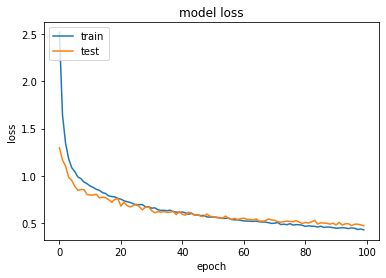

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

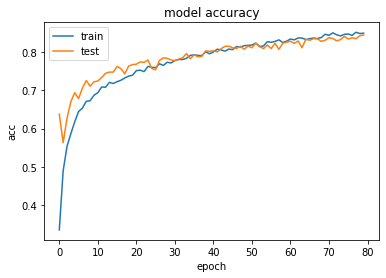

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predict_x=model.predict(x_testcnn) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
classes_x

In [ ]:
y_test

array([4, 3, 2, ..., 3, 4, 5])

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([4, 3, 2, ..., 3, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       482
           1       0.75      0.84      0.79       464
           2       0.83      0.89      0.85       479
           3       0.83      0.84      0.84       485
           4       0.93      0.82      0.87       484
           5       0.87      0.84      0.86       474

    accuracy                           0.84      2868
   macro avg       0.85      0.84      0.84      2868
weighted avg       0.85      0.84      0.84      2868



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, classes_x)
print (matrix)

# 0 = Educational, 1 = Gaming, 2 = News, 3 = Scenery, 4 = Song, 5 = Sports

[[403  20  35  14   3   7]
 [ 12 390  21  13  12  16]
 [  9  19 424  14   0  13]
 [ 16  36   6 408   8  11]
 [ 13  21  12  30 398  10]
 [  6  35  15  12   9 397]]


In [ ]:
model_name = 'video_classification_with_audio_1.h5'
save_dir = '/content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model/video_classification_with_audio_1.h5 


In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Thesis/Media Data Filtering/Saved_Model/video_classification_with_audio_1.h5')
loaded_model.summary()

In [ ]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

90/90 [==============================] - 0s 3ms/step - loss: 0.5531 - accuracy: 0.8309
Restored model, accuracy: 83.09%


In [ ]:
predict_x=loaded_model.predict(x_testcnn) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, classes_x)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, classes_x)
print (matrix)